# Detecting CyberSecurity Threats using Deep Learning
This is a notebook that has the code from datacamp's project about anomaly detection with PyTorch

In [42]:
# Make sure to run this cell to use torchmetrics. If you cannot use pip install to install the torchmetrics, you can use sklearn.
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [43]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics import Accuracy
# from sklearn.metrics import accuracy_score  # uncomment to use sklearn

In [44]:
train_df = pd.read_csv("data/labelled_train.csv")
val_df = pd.read_csv("data/labelled_validation.csv")
test_df = pd.read_csv("data/labelled_test.csv")

In [45]:
# Separate features and target
train_features = train_df.drop(columns=["sus_label"]).values
train_target = train_df['sus_label'].values.astype(float)

# Scale the features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)

# Convert to PyTorch tensors
train_dataset = TensorDataset(
    torch.tensor(train_features_scaled).float(),
    torch.tensor(train_target).float().reshape(-1, 1)  # Reshape target to match model output
)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [46]:
# Separate features and target
val_features = val_df.drop(columns=["sus_label"]).values
val_target = val_df['sus_label'].values.astype(float)

# Scale the features
val_features_scaled = scaler.fit_transform(val_features)

# Convert to PyTorch tensors
val_dataset = TensorDataset(
    torch.tensor(val_features_scaled).float(),
    torch.tensor(val_target).float().reshape(-1, 1)  # Reshape target to match model output
)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [47]:
def load_and_preprocess_data(file_path, scaler=None, fit_scaler=False):
    """
    Load data from a CSV file, separate features and target, scale features, and convert to PyTorch tensors.
    
    Parameters:
    - file_path (str): Path to the CSV file.
    - scaler (StandardScaler): Scaler object for scaling features. If None, a new scaler will be created.
    - fit_scaler (bool): Whether to fit the scaler on the data. Should be True for training data and False for validation/test data.
    
    Returns:
    - dataloader (DataLoader): DataLoader object for the dataset.
    - scaler (StandardScaler): Scaler object used for scaling features.
    """
    # Load data
    df = pd.read_csv(file_path)
    
    # Separate features and target
    features = df.drop(columns=["sus_label"]).values
    target = df['sus_label'].values.astype(float)
    
    # Scale the features
    if scaler is None:
        scaler = StandardScaler()
    if fit_scaler:
        features_scaled = scaler.fit_transform(features)
    else:
        features_scaled = scaler.transform(features)
    
    # Convert to PyTorch tensors
    dataset = TensorDataset(
        torch.tensor(features_scaled).float(),
        torch.tensor(target).float().reshape(-1, 1)  # Reshape target to match model output
    )
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    return dataloader, scaler

# Load and preprocess datasets
train_dataloader, scaler = load_and_preprocess_data("data/labelled_train.csv", fit_scaler=True)
val_dataloader, _ = load_and_preprocess_data("data/labelled_validation.csv", scaler=scaler)
test_dataloader, _ = load_and_preprocess_data("data/labelled_test.csv", scaler=scaler)

In [48]:
# Model definition (using Sequential this time for simplicity)
model = nn.Sequential(
    nn.Linear(7, 16),  # 7 input features
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)

# can be done with a class and a forward method

In [52]:
# Loss function and optimizer
class_weights = torch.tensor([0.001, 0.999])  # Adjust the weights based on class imbalance
pos_weight = torch.tensor([10.0])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)

accuracy = Accuracy(task='binary')
# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train_losses = []
    # training
    print("training...")
    model.train()
    for batch_features, batch_targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(batch_features)
        
        loss = criterion(outputs, batch_targets)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    with torch.no_grad():
        print("deriving training accuracy")
        train_accuracy = accuracy(outputs, batch_targets)
        
    # validation
    print("validating...")
    val_losses = []
    model.eval()
    with torch.no_grad():
        for val_features, val_targets in val_dataloader:
            predictions = model(val_features)
            val_loss = criterion(predictions, val_targets)
            val_losses.append(val_loss.item())
        print("deriving validation accuracy")
        val_accuracy = accuracy(predictions, val_targets)
    
    train_losses = np.array(train_losses).mean()
    val_losses = np.array(val_losses).mean()

    print(f'training_loss: {round(train_losses, 4)}  training_accuracy: '+ f'{train_accuracy}  validation_loss: {round(val_losses, 4)} '+ f'validation_accuracy: {val_accuracy}\n')

Epoch 1/5
training...
deriving training accuracy
validating...
deriving validation accuracy
training_loss: 0.6984  training_accuracy: 1.0  validation_loss: 0.7035 validation_accuracy: 1.0

Epoch 2/5
training...
deriving training accuracy
validating...
deriving validation accuracy
training_loss: 0.6984  training_accuracy: 1.0  validation_loss: 0.7035 validation_accuracy: 1.0

Epoch 3/5
training...
deriving training accuracy
validating...
deriving validation accuracy
training_loss: 0.6984  training_accuracy: 1.0  validation_loss: 0.7035 validation_accuracy: 1.0

Epoch 4/5
training...
deriving training accuracy
validating...
deriving validation accuracy
training_loss: 0.6984  training_accuracy: 1.0  validation_loss: 0.7035 validation_accuracy: 1.0

Epoch 5/5
training...
deriving training accuracy
validating...
deriving validation accuracy
training_loss: 0.6984  training_accuracy: 1.0  validation_loss: 0.7035 validation_accuracy: 1.0



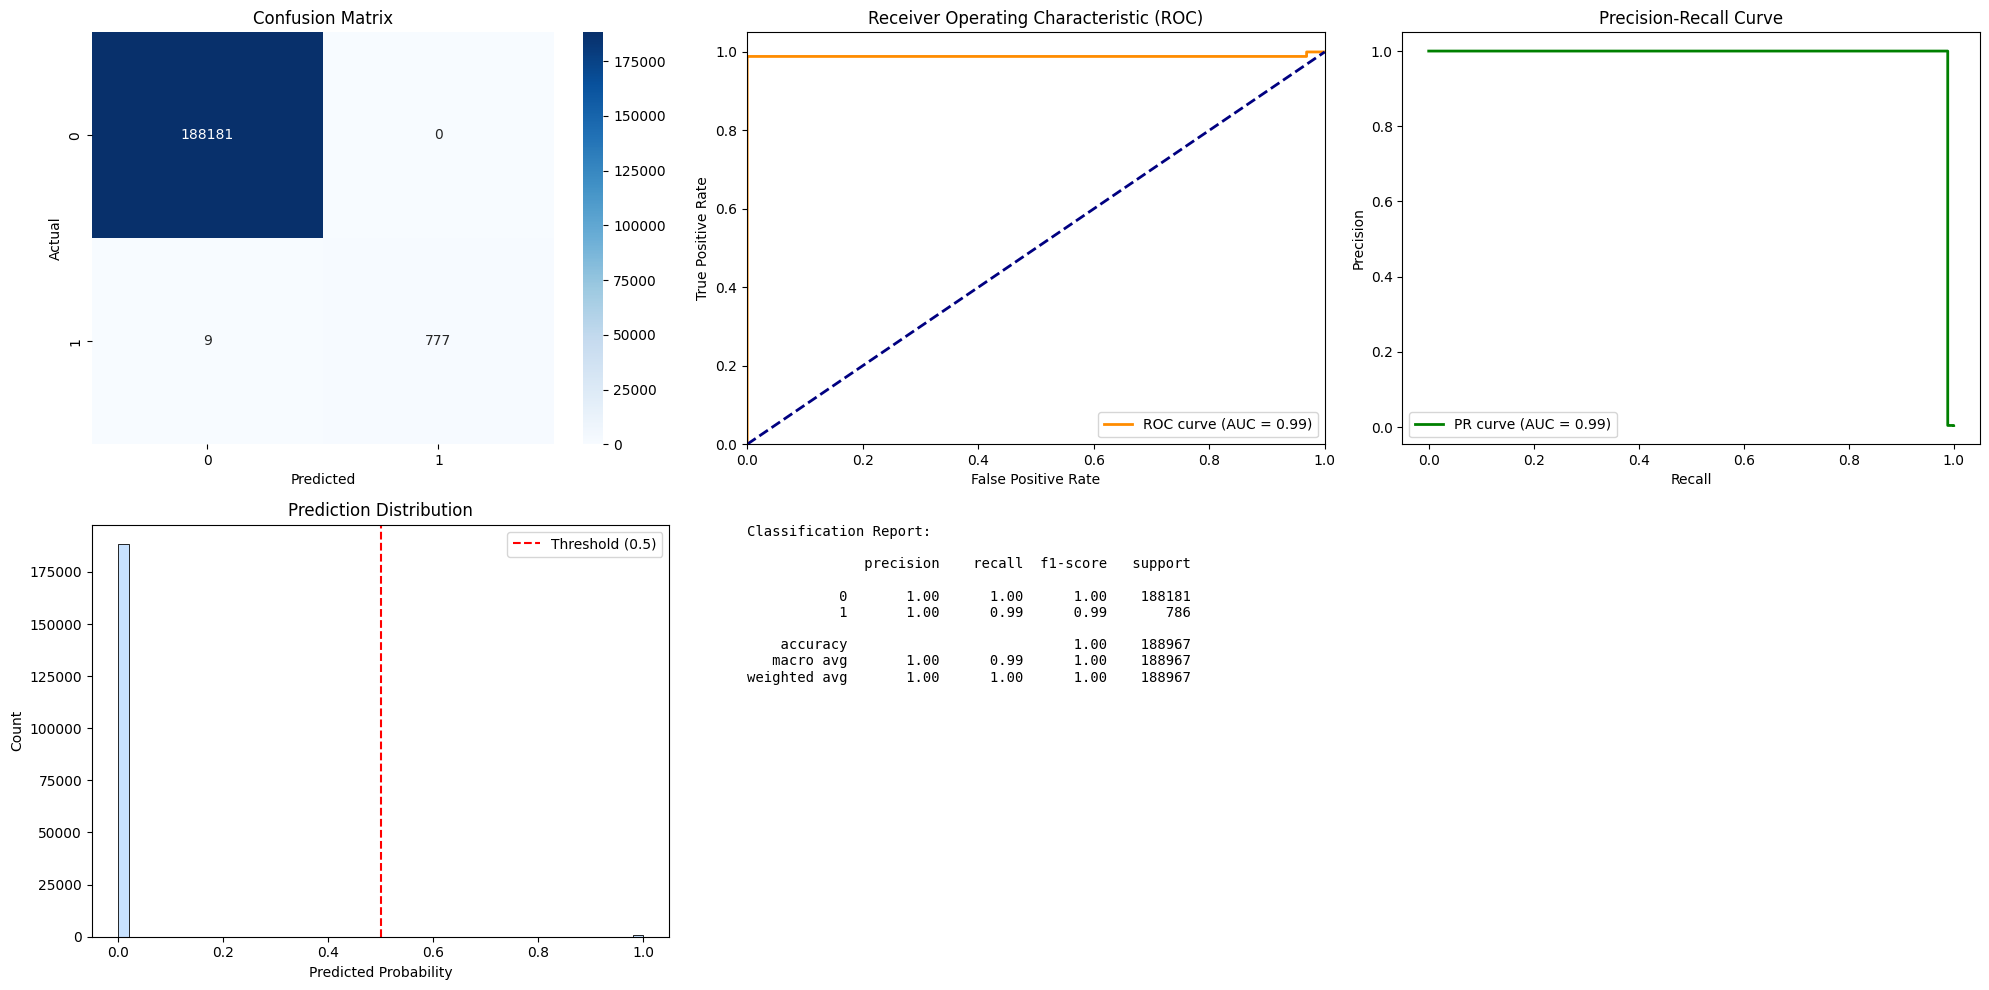

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import pandas as pd

def evaluate_model(model, val_df, scaler, threshold=0.5):
    """
    Evaluate the model using various metrics and create visualizations
    """
    # Prepare validation data
    val_features = val_df.drop(columns=["sus_label"]).values
    val_targets = val_df['sus_label'].values
    
    # Scale features
    val_features_scaled = scaler.transform(val_features)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        val_tensor = torch.tensor(val_features_scaled).float()
        val_preds_raw = model(val_tensor).numpy()
        val_preds = (val_preds_raw >= threshold).astype(int)
    
    # Calculate metrics
    conf_matrix = confusion_matrix(val_targets, val_preds)
    class_report = classification_report(val_targets, val_preds)
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(val_targets, val_preds_raw)
    roc_auc = auc(fpr, tpr)
    
    # Calculate Precision-Recall curve
    precision, recall, _ = precision_recall_curve(val_targets, val_preds_raw)
    pr_auc = auc(recall, precision)
    
    # Create figure with subplots
    plt.style.use('seaborn-v0_8-pastel')
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Confusion Matrix
    plt.subplot(2, 3, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    # 2. ROC Curve
    plt.subplot(2, 3, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    
    # 3. Precision-Recall Curve
    plt.subplot(2, 3, 3)
    plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    
    # 4. Prediction Distribution
    plt.subplot(2, 3, 4)
    sns.histplot(val_preds_raw, bins=50)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Count')
    plt.legend()
    
    # Add classification report as text
    plt.subplot(2, 3, 5)
    plt.axis('off')
    plt.text(0, 1, f"Classification Report:\n\n{class_report}", 
             fontsize=10, family='monospace', 
             verticalalignment='top')
    
    plt.tight_layout()
    plt.show()
    
    # Return metrics for further analysis if needed
    return {
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'predictions': val_preds_raw
    }

# Create a history tracking function for training
# def train_with_history(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10):
#     """
#     Train the model and track metrics over time
#     """
#     history = {
#         'train_loss': [],
#         'val_loss': [],
#         'val_accuracy': []
#     }
    
#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         train_loss = 0
#         for batch_features, batch_targets in train_dataloader:
#             optimizer.zero_grad()
#             outputs = model(batch_features)
#             loss = criterion(outputs, batch_targets)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item()
        
#         avg_train_loss = train_loss / len(train_dataloader)
        
#         # Validation phase
#         model.eval()
#         val_loss = 0
#         correct = 0
#         total = 0
        
#         with torch.no_grad():
#             for batch_features, batch_targets in val_dataloader:
#                 outputs = model(batch_features)
#                 loss = criterion(outputs, batch_targets)
#                 val_loss += loss.item()
                
#                 predicted = (outputs >= 0.5).float()
#                 total += batch_targets.size(0)
#                 correct += (predicted == batch_targets).sum().item()
        
#         avg_val_loss = val_loss / len(val_dataloader)
#         accuracy = correct / total
        
#         # Store metrics
#         history['train_loss'].append(avg_train_loss)
#         history['val_loss'].append(avg_val_loss)
#         history['val_accuracy'].append(accuracy)
        
#         print(f'Epoch [{epoch+1}/{num_epochs}]')
#         print(f'Train Loss: {avg_train_loss:.4f}')
#         print(f'Val Loss: {avg_val_loss:.4f}')
#         print(f'Val Accuracy: {accuracy:.4f}\n')
    
#     # Plot training history
#     plt.figure(figsize=(15, 5))
    
#     # Plot losses
#     plt.subplot(1, 2, 1)
#     plt.plot(history['train_loss'], label='Train Loss')
#     plt.plot(history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss Over Time')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
    
#     # Plot accuracy
#     plt.subplot(1, 2, 2)
#     plt.plot(history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Model Accuracy Over Time')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
    
#     plt.tight_layout()
#     plt.show()
    
#     return history

# # Example usage:
# # First prepare validation data
# val_dataset = TensorDataset(
#     torch.tensor(scaler.transform(val_df.drop(columns=["sus_label"]).values)).float(),
#     torch.tensor(val_df['sus_label'].values).float().reshape(-1, 1)
# )
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Train model with history tracking
# history = train_with_history(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=10)

# # Evaluate model
metrics = evaluate_model(model, val_df, scaler)

In [ ]:
import matplotlib.pyplot as plt
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
